In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import kstest

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import IsolationForest

import statsmodels.api as sm
import sys

In [2]:
#Importar os dados
df = pd.read_csv('base_dummy.csv')
df_original = pd.read_csv('Base mesclada.csv')

colunas_escolhidas = ['BsmtFinType1','GarageFinish']
novas_colunas = ['Qualidade do acabamento do porão','Acabamento da Garagem']
df[novas_colunas] = df_original[colunas_escolhidas]

# Substituir o NaN pelo valor 'Nao possui'
def consertar(x):
    if str(x) == 'nan':
        return 'Nao possui'
    return x
    
df['Acabamento da Garagem'] = df[['Acabamento da Garagem']].applymap(consertar)
df['Qualidade do acabamento do porão'] = df[['Qualidade do acabamento do porão']].applymap(consertar)
df = df.drop(df[df['Zona'].isna()].index)
df = df.drop(df[df['Área da Garagem'].isna()].index)

# Verifico quais sao as variaveis nao categoricas
objects = ['object']
df_numerical = df.select_dtypes(exclude=objects)
colunas_para_Regressao_Logistica = df_numerical.columns


- Normalidade multivariada Acho que OK!
- Linearidade ???????
- Ausência de outliers OK, só retirei os outliers!
- Ausência de multicolinearidade  (Conclusão: precisei descartar vários atributos - através do VIF - variance inflation factor - fator de inflação de variância)
- Homogeneidade das matrizes de variância/co-variância (Teria que usar função BoxM do R -> não fiz isso)

### Ausência de multicolinearidade (Conclusão: precisei descartar vários atributos)

In [3]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(df[colunas_para_Regressao_Logistica].to_numpy(), i) for i in range(df[colunas_para_Regressao_Logistica].shape[1])]
vif['Atributo'] = colunas_para_Regressao_Logistica
vif

/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,Atributo
0,1.560332,Preço da venda
1,1.313615,Número de Quartos
2,1.555471,Área da Garagem
3,1.187081,Área do Lote
4,1.773849,Número de Banheiros
5,2.118099,Idade do Imóvel
6,inf,Alta Densidade Residencial
7,inf,Baixa Densidade Residencial
8,inf,Comercial
9,inf,Média Densidade Residencial


- VIF = 1: indica que não há correlação entre uma determinada variável explicativa e quaisquer outras variáveis explicativas no modelo.
- 1 < VIF <= 5: indica correlação moderada entre uma determinada variável explicativa e outras variáveis explicativas no modelo, mas isso geralmente não é severo o suficiente para requerer atenção.
- VIF > 5: Um valor maior que 5 indica correlação potencialmente severa entre uma determinada variável explicativa e outras variáveis explicativas no modelo. Nesse caso, as estimativas de coeficiente e os valores de p na saída da regressão provavelmente não são confiáveis.

In [4]:
novas_colunas = colunas_para_Regressao_Logistica.copy()

while True:
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(df[novas_colunas].to_numpy(), i) for i in range(df[novas_colunas].shape[1])]
    vif['Atributo'] = novas_colunas
    id_excluir = vif['VIF'].idxmax()
    if vif['VIF'].max() > 5:
        novas_colunas = novas_colunas.drop(novas_colunas[id_excluir])
    else:
        break
vif

/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,Atributo
0,2.920678,Área da Garagem
1,2.886081,Área do Lote
2,3.437154,Idade do Imóvel
3,1.053198,Comercial
4,1.525701,Média Densidade Residencial
5,1.101495,Vila Flutuante Residencial
6,1.425561,Bom
7,1.851966,Médio
8,1.142929,Razoável
9,1.006357,Ruim


In [5]:
df_para_reg_log = df[novas_colunas]
df_para_reg_log.head()

,Área da Garagem,Área do Lote,Idade do Imóvel,Comercial,Média Densidade Residencial,Vila Flutuante Residencial,Bom,Médio,Razoável,Ruim
0,548.0,8450,5,0,0,0,0,0,0,0
1,460.0,9600,31,0,0,0,0,0,0,0
2,608.0,11250,7,0,0,0,0,0,0,0
3,642.0,9550,91,0,0,0,1,0,0,0
4,836.0,14260,8,0,0,0,0,0,0,0


## variável dependente: Qualidade do acabamento do porão

In [6]:
X = df_para_reg_log.copy().values
y = df['Acabamento da Garagem'].loc[df_para_reg_log.index].values

In [7]:
# Uso metodo holdout para separar conjunto de treinamento e conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [8]:
# Defino colunas para o relatorio de sumario
df_para_reg_log.columns
colunas_summary = ['intercepto']
colunas_summary = colunas_summary+list(df_para_reg_log.columns)
colunas_summary

['intercepto',
 'Área da Garagem',
 'Área do Lote',
 'Idade do Imóvel',
 'Comercial',
 'Média Densidade Residencial',
 'Vila Flutuante Residencial',
 'Bom',
 'Médio',
 'Razoável',
 'Ruim']

In [9]:
df['Acabamento da Garagem'].loc[df_para_reg_log.index].value_counts()

Unf           1226
RFn            811
Fin            719
Nao possui     158
Name: Acabamento da Garagem, dtype: int64

In [10]:
model = sm.MNLogit(y_train, sm.add_constant(X_train))
result = model.fit_regularized() 

result.summary(xname=colunas_summary)

/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2290: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2291: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]
/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2322: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2323: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.7760805810167579
            Iterations: 254
            Function evaluations: 300
            Gradient evaluations: 254


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                 2185
Model:                        MNLogit   Df Residuals:                     2152
Method:                           MLE   Df Model:                           30
Date:                Tue, 23 Nov 2021   Pseudo R-squ.:                  0.3605
Time:                        19:14:20   Log-Likelihood:                -1695.7
converged:                       True   LL-Null:                       -2651.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
               y=Nao possui       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
intercepto                      3.9279      1.909      2.058      0.040       0.187       7.669
Área da Garagem                -0.0482      0.008     -6.392      0.000      -0.063      -0.033
Área do Lote                 3.943e-05   6.59e-05      0.598      0.550   -8.98e-05       0.000
Idade do Imóvel                 0.0489      0.027      1.787      0.074      -0.005       0.102
Comercial                       6.9954     76.687      0.091      0.927    -143.309     157.300
Média Densidade Residencial     0.5953      1.389      0.429      0.668      -2.126       3.317
Vila Flutuante Residencial     -0.0018   1148.799  -1.53e-06      1.000   -2251.606    2251.602
Bom                             1.8705      1.688      1.108      0.268      -1.438       5.179
Médio                           1.4337      1.634      0.878      0.380      -1.768       4.636
Razoável                        1.4025      2.942      0.477      0.634      -4.363       7.168
Ruim                           -0.0024   2.18e+05  -1.08e-08      1.000   -4.28e+05    4.28e+05
-----------------------------------------------------------------------------------------------
                      y=RFn       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
intercepto                     -0.0775      0.248     -0.313      0.754      -0.563       0.408
Área da Garagem              7.636e-05      0.000      0.204      0.838      -0.001       0.001
Área do Lote                 -1.49e-05   7.94e-06     -1.877      0.060   -3.05e-05    6.57e-07
Idade do Imóvel                 0.0173      0.004      4.165      0.000       0.009       0.025
Comercial                       8.5727     76.594      0.112      0.911    -141.550     158.695
Média Densidade Residencial    -0.8659      0.292     -2.961      0.003      -1.439      -0.293
Vila Flutuante Residencial      0.3001      0.247      1.216      0.224      -0.184       0.784
Bom                            -0.1989      0.190     -1.048      0.295      -0.571       0.173
Médio                           0.3916      0.202      1.942      0.052      -0.004       0.787
Razoável                       -0.1494      0.605     -0.247      0.805      -1.334       1.035
Ruim                           -5.7820   3.49e+04     -0.000      1.000   -6.85e+04    6.85e+04
-----------------------------------------------------------------------------------------------
                      y=Unf       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
intercepto                     -1.0106      0.295     -3.422      0.001      -1.589      -0.432
Área da Garagem                -0.0015      0.000     -3.207      0.001      -0.002      -0.001
Área do Lote                -2.065e-05   8.89e-06     -2.323      0.020  

P>|z|:
As variaveis abaixo de 0.05 são significativas. Entretanto, vemos que há muitas variáveis que se mostram não significativas

In [11]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: MNLogit
=================================================================
Model:               MNLogit          Pseudo R-squared: 0.360    
Dependent Variable:  y                AIC:              3457.4721
Date:                2021-11-23 19:14 BIC:              3645.2214
No. Observations:    2185             Log-Likelihood:   -1695.7  
Df Model:            30               LL-Null:          -2651.6  
Df Residuals:        2152             LLR p-value:      0.0000   
Converged:           1.0000           Scale:            1.0000   
No. Iterations:      254.0000                                    
-----------------------------------------------------------------
y = 0  Coef.    Std.Err.     t    P>|t|     [0.025       0.975]  
-----------------------------------------------------------------
const  3.9279      1.9088  2.0578 0.0396       0.1868      7.6691
   x1 -0.0482      0.0075 -6.3920 0.0000      -0.0630     -0.0334
   x2  0.0000      0.0001  0.5980 0.5498      -0.0001      0.0002
   x3  0.0489      0.0274  1.7865 0.0740      -0.0047      0.1025
   x4  6.9954     76.6874  0.0912 0.9273    -143.3090    157.2999
   x5  0.5953      1.3886  0.4287 0.6681      -2.1264      3.3170
   x6 -0.0018   1148.7987 -0.0000 1.0000   -2251.6059   2251.6024
   x7  1.8705      1.6878  1.1083 0.2678      -1.4375      5.1786
   x8  1.4337      1.6337  0.8776 0.3802      -1.7683      4.6357
   x9  1.4025      2.9415  0.4768 0.6335      -4.3628      7.1678
  x10 -0.0024 218370.9772 -0.0000 1.0000 -427999.2530 427999.2482
-----------------------------------------------------------------
 y = 1    Coef.   Std.Err.     t    P>|t|     [0.025     0.975]  
-----------------------------------------------------------------
const    -0.0775     0.2477 -0.3130 0.7543     -0.5630     0.4080
   x1     0.0001     0.0004  0.2044 0.8381     -0.0007     0.0008
   x2    -0.0000     0.0000 -1.8772 0.0605     -0.0000     0.0000
   x3     0.0173     0.0042  4.1649 0.0000      0.0092     0.0255
   x4     8.5727    76.5945  0.1119 0.9109   -141.5497   158.6951
   x5    -0.8659     0.2924 -2.9614 0.0031     -1.4390    -0.2928
   x6     0.3001     0.2468  1.2157 0.2241     -0.1837     0.7838
   x7    -0.1989     0.1898 -1.0481 0.2946     -0.5710     0.1731
   x8     0.3916     0.2017  1.9419 0.0521     -0.0036     0.7868
   x9    -0.1494     0.6045 -0.2472 0.8048     -1.3342     1.0354
  x10    -5.7820 34947.1049 -0.0002 0.9999 -68500.8491 68489.2850
-----------------------------------------------------------------
y = 2   Coef.    Std.Err.     t     P>|t|     [0.025      0.975] 
-----------------------------------------------------------------
const  -1.0106     0.2953  -3.4220  0.0006     -1.5894    -0.4318
   x1  -0.0015     0.0005  -3.2068  0.0013     -0.0023    -0.0006
   x2  -0.0000     0.0000  -2.3225  0.0202     -0.0000    -0.0000
   x3   0.0640     0.0042  15.2337  0.0000      0.0558     0.0723
   x4   5.9026    76.5946   0.0771  0.9386   -144.2200   156.0252
   x5   0.4439     0.2548   1.7419  0.0815     -0.0556     0.9433
   x6   1.3082     0.3064   4.2696  0.0000      0.7077     1.9087
   x7   0.1155     0.1984   0.5823  0.5604     -0.2733     0.5044
   x8   0.9367     0.1936   4.8389  0.0000      0.5573     1.3161
   x9   0.6644     0.5243   1.2673  0.2051     -0.3632     1.6920
  x10  12.6597  2154.7180   0.0059  0.9953  -4210.5099  4235.8294
=================================================================

"""

In [12]:
y_pred_aux = result.predict(sm.add_constant(X_test))
valores_originais = ['Fin','Nao possui','RFn','Unf']
y_pred = []
for linha in y_pred_aux:
    #     y_pred.append(linha.argmax())
    y_pred.append(valores_originais[linha.argmax()])

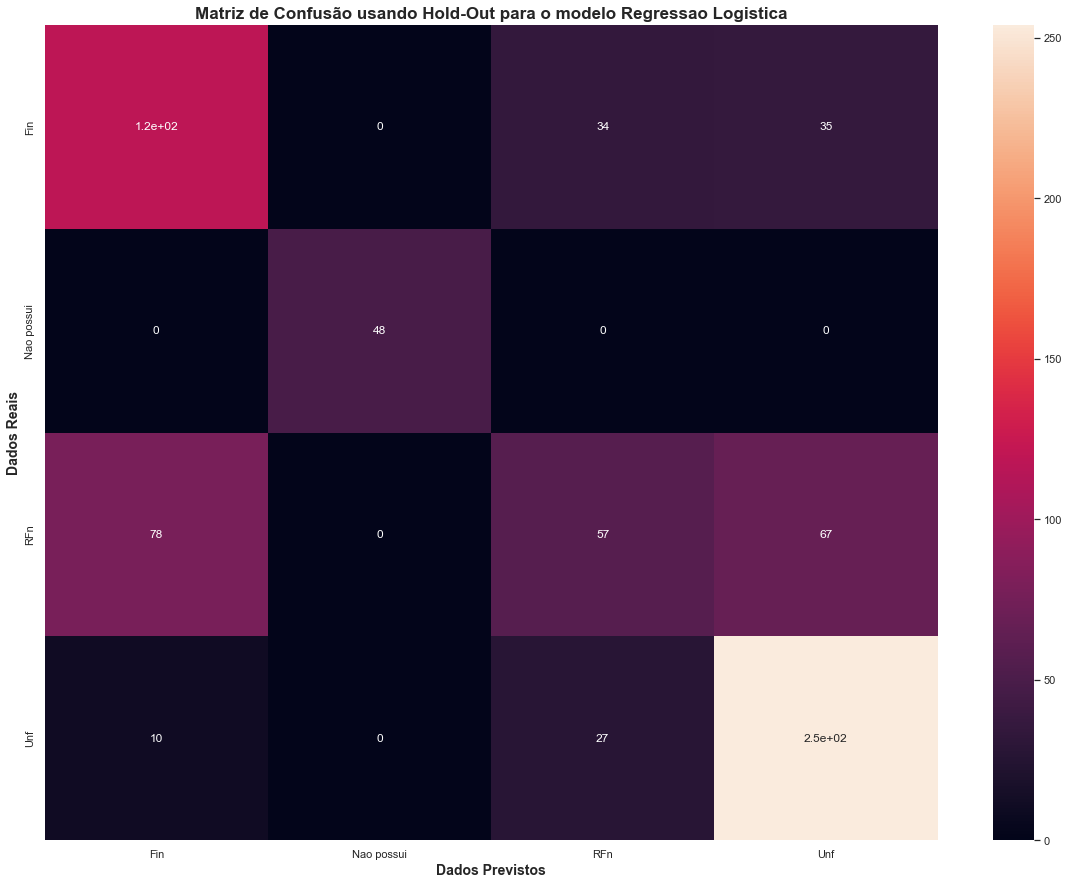

In [18]:
# y_pred = np.array(y_pred)
arr = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(arr, columns=np.unique(y_test), index = np.unique(y_test))
ax = sns.heatmap(df_cm, annot=True)
# ax.set(xlabel='Dados Previstos', ylabel='Dados Reais',fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlabel("Dados Previstos",fontdict = {'fontsize':14,'fontweight':'bold'})
plt.ylabel("Dados Reais",fontdict = {'fontsize':14,'fontweight':'bold'})
sns.set(rc={'figure.figsize':(20,15)})
plt.title("Matriz de Confusão usando Hold-Out para o modelo Regressao Logistica",fontdict = {'fontsize':17,'fontweight':'bold'})
plt.show()

In [14]:
print("Acurácia split validation com o conjunto de teste = " + str((y_test == y_pred).sum()/y_test.shape[0]))

Acurácia split validation com o conjunto de teste = 0.6556927297668038


In [15]:
# Funcao para realizar cross validation no modelo statsmodel (Nao existe cross validation para esta biblioteca)
def k_fold_cross_validation(X, y, k, modelo):
    intervalo = int(y.shape[0]/k)
    intervalos = [(x + 1)*intervalo for x in range(k)]
    intervalos[-1] = y.shape[0]    
    limite_inferior = 0
    erro_folds = []
    for limite_superior in intervalos:
        x_test = X[limite_inferior:limite_superior]            
        y_test = y[limite_inferior:limite_superior] 
        x_train = np.concatenate((X[0:limite_inferior],X[limite_superior:]))
        y_train = np.concatenate((y[0:limite_inferior],y[limite_superior:]))
        limite_inferior = limite_superior
        
        obj = modelo(y_train, sm.add_constant(x_train))
        
        #treinar modelo
        result = obj.fit_regularized()      
        
        y_pred_aux = result.predict(sm.add_constant(x_test))
        valores_originais = ['Fin','Nao possui','RFn','Unf']
        y_pred = []
        for linha in y_pred_aux:
            y_pred.append(valores_originais[linha.argmax()])
        
        
        #registrar os erros de cada fold
        erro_folds.append(((y_test == y_pred).sum()/y_test.shape[0]))        
                        
        #registrar a media artimetica dos erros
    return sum(erro_folds)/len(erro_folds), erro_folds

In [16]:
acc_X_val, acc_X_val_folds = k_fold_cross_validation(X_train,y_train,10,sm.MNLogit)

/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2290: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2291: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]
/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2322: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
/Users/yamada/miniconda3/envs/.venv/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2323: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.7745794048915169
            Iterations: 249
            Function evaluations: 294
            Gradient evaluations: 249
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.7820237322998711
            Iterations: 239
            Function evaluations: 282
            Gradient evaluations: 239
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.7786547649958138
            Iterations: 233
            Function evaluations: 276
            Gradient evaluations: 233
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.7707775406610364
            Iterations: 246
            Function evaluations: 293
            Gradient evaluations: 246
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.779337122975761
            Iterations: 238
            

In [17]:
print("Acurácia 10-fold Cross Validation Regressao Logistica = " + str(acc_X_val))

Acurácia 10-fold Cross Validation Regressao Logistica = 0.610661537828609
